我们的理想同化实验如下设计：我们使用的自然模式（构成真实场）的模式为多尺度Lorenz96模式（Lorenz 1996, Wilk,2005）

多尺度洛伦茨1996模式由以下方程定义，它包含了两个尺度的变量，通过耦合项耦合在一起
\begin{equation}
\frac{dX_k}{dt}=X_{k-1} (X_{k+1}-X_{k-2} )-X_k+F-\frac{hc}{b}\sum\limits_{j=1}^{J} Z_{j,k},\\
\frac{dZ_{j,k}}{dt}=cbZ_{j+1,k} (Z_{j-1,k}-Z_{j+2,k} )-cZ_{j,k}+\frac{hc}{b} X_k,
\end{equation}
方程1是大尺度变量X；方程2是小尺度变量Z; 我们使用K = 8, J = 16, 那么意味着8\*16个小尺度变量变量和8个大尺度变量耦合，每16个Z变量影响一个X变量。我们将上述模式视为“自然模式”，提供精确解进行比对。自然模式的积分步长设置为$\Delta t=0.005$。

假设实际运行的模式是大尺度模式，且模式积分步长为$\delta t = 0.05$，小尺度模式的变量无法解析。因此需要引入参数化方程：
\begin{equation}\frac{\mathrm{d} X_{k}^{*}}{\mathrm{d} t}=-X_{k-1}^{*}\left(X_{k-2}^{*}-X_{k+1}^{*}\right)-X_{k}^{*}+F-g_{U}\left(X_{k}^{*}\right) ; \quad k=1, \ldots, K\end{equation}
其中
$g_{U}$是参数化函数，假设它可以取成多项式形式，就可以使用相应的方法确定参数
\begin{equation}g_{U}\left(X_{k}^{*}\right)= \sum_{n=0}^{N}b_n (X_k^{*})^n
\end{equation}

In [1]:
# In[init path]
import numpy as np;
import os
case_dir = "/Users/shenzheqi/test_python_local/tvr_PESE/"
if not os.path.exists(case_dir):
    os.makedirs(case_dir)
if not os.path.exists(case_dir+'DATA'):
    os.makedirs(case_dir+'DATA')
if not os.path.exists(case_dir+'INITENS'):
    os.makedirs(case_dir+'INITENS')
if not os.path.exists(case_dir+'output'):
    os.makedirs(case_dir+'output')
if not os.path.exists(case_dir+'figure'):
    os.makedirs(case_dir+'figure')

In [2]:
# In[def model]
class msL96_para:
    name = 'multi-scale Lorenz 96 model parameter'
    K = 8; J = 16; F = 8;
    c = 10; b = 10; h = 1    
def Lmodel_rhs(x,Force):
    dx = (np.roll(x,-1)-np.roll(x,2))*np.roll(x,1)-x + Force
    return dx
def Smodel_rhs(z,Force):  
    Para = msL96_para()
    c = Para.c; b = Para.b
    dz = c*b*(np.roll(z,1)-np.roll(z,-2))*np.roll(z,-1)-c*z + Force
    return dz
def msL96_rhs(Y):
    Para = msL96_para()
    K = Para.K; J = Para.J
    c = Para.c; b = Para.b; h = Para.h;   
    X = Y[range(K)]
    Z = Y[range(K,len(Y))]    
    # 
    SumZ = np.sum(np.reshape(Z,(K,J)),axis=1)
    forcing_X = Para.F - h*c/b*SumZ
    dX = Lmodel_rhs(X,forcing_X)  
    forcing_Z = h*c/b*np.kron(X,np.ones(J))
    dZ = Smodel_rhs(Z,forcing_Z)
    dY = np.concatenate((dX,dZ),axis=0)
    return dY
def RK45(x,func,h):
    # 
    K1=func(x);
    K2=func(x+h/2*K1);
    K3=func(x+h/2*K2);
    K4=func(x+h*K3);
    x1=x+h/6*(K1+2*K2+2*K3+K4);
    return x1
def msL96_adv_1step(x0,delta_t):
    # run the coupled model
    x1=RK45(x0,msL96_rhs,delta_t)
    return x1
def Lmodel_adv_1step(x0,delta_t,Force):
    # run the X model with prescribed forcing term
    x1=RK45(x0,lambda x:Lmodel_rhs(x,Force),delta_t)
    return x1
def L96para_adv_1step(x0,delta_t,Force,polyCof):
    aU = np.poly1d(polyCof)
    x1=RK45(x0,lambda x:Lmodel_rhs(x,Force-aU(x)),delta_t)
    return x1

In [3]:
# In[spinup]
if not os.path.exists(case_dir+'DATA/'):
    os.makedirs(case_dir+'DATA/')
if not os.path.exists(case_dir+'DATA/MSx0true.npz'):
    Para = msL96_para()
    K = Para.K
    J = Para.J
    delta_t = 0.005
    x0spinup = np.random.randn(K+K*J);x0 = x0spinup;
    for j in range(10000):
        x1 = msL96_adv_1step(x0,delta_t)
        x0 = x1
    print('finish spinup, save data')
    np.savez(case_dir+'DATA/MSx0true.npz',x1)
    x0true = x1
else:
    TMP_DAT = np.load(case_dir+'DATA/MSx0true.npz')
    print('load spinup data')
    x0true = TMP_DAT['arr_0']

load spinup data


In [4]:
# In[create_truth]
Para = msL96_para()
K = Para.K;J = Para.J
F = Para.F;
h = Para.h; c = Para.c; b=Para.b
delta_t = 0.005    # the step size for nature run is delta_t
period_steps = 20000;

if not os.path.exists(case_dir+'DATA/MStrue_data.npz'):
    Xtrue = np.zeros([period_steps,K])
    Ytrue = np.zeros([period_steps,K*J])
    x0 = x0true
    for j in range(period_steps):
        x1 = msL96_adv_1step(x0,delta_t)
        Xtrue[j] = x0[range(K)]
        Ytrue[j] = x0[range(K,K*J+K)]
        x0=x1
    np.savez(case_dir+'DATA/MStrue_data.npz',Xtrue,Ytrue)
    print('generate truth')
else:
    TMP_DAT = np.load(case_dir+'DATA/MStrue_data.npz')
    print('load truth')
    Xtrue = TMP_DAT['arr_0'];Ytrue=TMP_DAT['arr_1']

load truth


参考(Wilks,2005)，多项式参数化系数可以使用X和公式1最右边的耦合项进行多项式拟合得到。为了简化讨论，使用2次多项式。

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


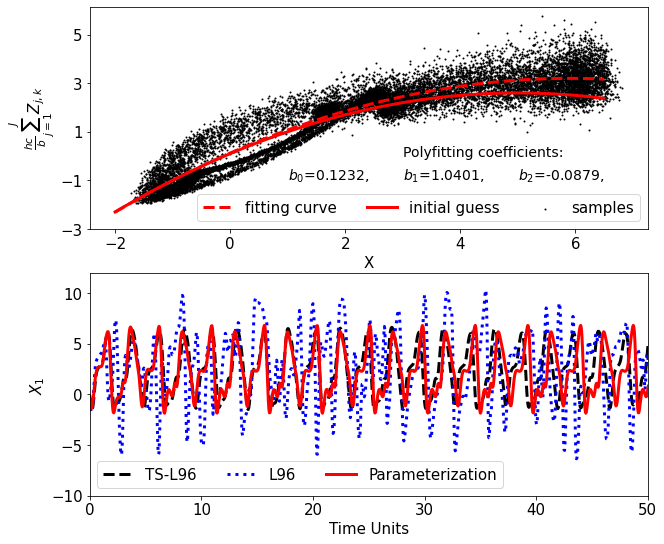

In [7]:
# In[fitting parameter with true data]
# deterministic parameterization for U by 2th order polyfit   
dt = 0.05    # the model step size is dt.     
Nt = np.int(dt/delta_t)

Xu = Xtrue[range(0,period_steps,Nt)]  # truth for model's temporal resolution
Para_true = np.zeros_like(Xu)
for j in range(2000):
    Z = Ytrue[j*Nt]
    SumZ = np.sum(np.reshape(Z,(K,J)),axis=1)
    Para_true[j] = h*c/b*SumZ

z = np.polyfit(Xu.flatten(),Para_true.flatten(),2)
gU = np.poly1d(z)
xtt = np.linspace(-2,6.5,100)

pC0 = np.array([-0.1,1,0.1])
zU = np.poly1d(pC0)
# plot U again Xu and gU profile
import matplotlib.pyplot as plt
plt.figure(figsize=(10,9))
plt.subplot(2,1,1)
plt.scatter(Xu,Para_true,s=1,c='k',label='samples')
plt.plot(xtt,gU(xtt),'r--',lw = 3,label='fitting curve')
plt.plot(xtt,zU(xtt),'r',lw = 3,label='initial guess')
plt.legend(ncol = 3,fontsize=15)
plt.xticks(fontsize=15);plt.yticks(np.arange(-3,7,2),fontsize=15)

plt.text(3,0,'Polyfitting coefficients:',fontsize=14)
for j in range(len(z)):
    plt.text(1+2*j,-1,r'$b_'+str(j)+'$=%.4f'%z[2-j]+',',fontsize=14)
plt.xlabel('X',fontsize=15)
plt.ylabel(r'$\frac{hc}{b}\sum_{j=1}^{J} Z_{j,k}$',fontsize=15)

Xpara = np.zeros_like(Xu)
x0 = x0true[range(K)]
for j in range(len(Xpara)):
    x1 = L96para_adv_1step(x0,dt,F,zU)
    Xpara[j] = x1
    x0 = x1
Xctl = np.zeros_like(Xu)
x0 = x0true[range(K)]
for j in range(len(Xpara)):
    x1 = Lmodel_adv_1step(x0,dt,F)
    Xctl[j] = x1
    x0 = x1

plt.subplot(2,1,2)
plt.plot(np.arange(2000)*dt,Xu[:,0],'k--',lw=3,label='TS-L96')
plt.plot(np.arange(2000)*dt,Xctl[:,0],color='b',linestyle=':',lw=3,label='L96')
plt.plot(np.arange(2000)*dt,Xpara[:,0],'r-',lw=3,label='Parameterization') 
plt.xlabel('Time Units',fontsize=15)
plt.ylabel(r'$X_1$',fontsize=15)
plt.legend(ncol = 3,fontsize=15)  
plt.xticks(fontsize=15);plt.yticks(np.arange(-10,15,5),fontsize=15)
plt.xlim(0,50)
#plt.savefig(case_dir+'figure1.eps',format='eps')

使用2000个数据进行多项式拟合得到的系数大约是：$b_0=0.123$, $b_1=1.04$, $b_2=-0.0879$。为了开展后面的状态和参数估计实验，我们使用更粗糙一点儿的近似系数$[0.1,1,-0.1]$作为初始参数猜测。下图代表了使用该参数的结果和真实结果的比较，相比于只积分公式1的单尺度模式，参数化的效果能够体现。

## 状态估计实验
先开始状态估计实验：我们假设目标是使得变量$x_3,x_4,x_5,x_6$这四个变量整体的RMSE最小，同时，我们假设每次同化只同化两个观测点。使用20个member，因为X模式只有8个变量，此时可以不使用局地化。同化的观测资料是X模式的变量，假设每4步同化一次。此外需要注意参数化模式的步长为dt = 0.05（truth的步长为$\delta t=0.005$）
使用自适应观测的同化结果和固定观测的同化结果进行对比，比较RMSE和RMSS。同化的总时间为10个时间单位，或者2000模式步，

In [8]:
# In[def EAKF method]
def comp_cov_factor(z_in,c):
    z=abs(z_in);
    if z<=c:
        r = z/c;
        cov_factor=((( -0.25*r +0.5)*r +0.625)*r -5.0/3.0)*r**2 + 1.0;
    elif z>=c*2.0:
        cov_factor=0.0;
    else:
        r = z / c;
        cov_factor = ((((r/12.0 -0.5)*r +0.625)*r +5.0/3.0)*r -5.0)*r + 4.0 - 2.0 / (3.0 * r);
    return cov_factor;
# observation increment for the observation site
def obs_increment_eakf(ensemble, observation, obs_error_var):
    prior_mean = np.mean(ensemble);
    prior_var = np.var(ensemble);
    if prior_var >0.001:
        post_var = 1.0 / (1.0 / prior_var + 1.0 / obs_error_var);
        post_mean = post_var * (prior_mean / prior_var + observation / obs_error_var);
    else:
        post_var = prior_var;
        post_mean = prior_mean;    
    updated_ensemble = ensemble - prior_mean + post_mean;
    var_ratio = post_var / prior_var;
    updated_ensemble = np.sqrt(var_ratio) * (updated_ensemble - post_mean) + post_mean;
    obs_increments = updated_ensemble - ensemble;
    return obs_increments
# 
def eakf_analysis(ensemble_in,obs_in,obs_error_var,H_mat,LOC_MAT,H_op):
#    N = len(ensemble_in)
    L = len(ensemble_in[0]);     # model dimension (model grids)
    m = len(obs_in);    # number of obs sites
    # prior inflation not inside the analysis step
#    ens_mean = np.mean(ensemble_in,axis=0)
#    for n in range(N):
#        ensemble_in[n] = inf_in*(ensemble_in[n]-ens_mean)+ens_mean
    for i in range(m):
        ensemble_proj = H_op(ensemble_in,H_mat); 
        obs_proj = ensemble_proj[i];   # project model grid to obs site
        obs_inc = obs_increment_eakf(obs_proj,obs_in[i],obs_error_var);
        for j in range(L):
            covar = np.cov(ensemble_in[:,j], obs_proj);
            r = covar[0,1]/covar[1,1]
            cov_factor = LOC_MAT[j,i]
            # update ensemble
            if cov_factor>0:
                ensemble_in[:,j]=ensemble_in[:,j]+r*cov_factor*obs_inc;    
    ensemble_out = ensemble_in;
    return ensemble_out
def eakf_analysis_1obs(ensemble_in,obs_in,obs_error_var,H_mat,LOC_MAT,H_op):
    # use LOC_MAT, convient for CDA
    # inflation outside the function
    # for only 1 observation
    L = len(ensemble_in[0]);     # model dimension (model grids)
    ensemble_proj = H_op(ensemble_in,H_mat); 
    obs_proj = ensemble_proj;   # project model grid to obs site
    obs_inc = obs_increment_eakf(obs_proj,obs_in,obs_error_var);
    for j in range(L):
        covar = np.cov(ensemble_in[:,j], obs_proj);
        if covar[1,1]>0.001:
            r = covar[0,1]/covar[1,1]
        else:
            r=0
        cov_factor = LOC_MAT[j]                   
        # update ensemble
        if cov_factor>0:
            ensemble_in[:,j]=ensemble_in[:,j]+r*cov_factor*obs_inc;   
    ensemble_out = ensemble_in;
    return ensemble_out

In [9]:
Ne = 30
if not os.path.exists(case_dir+'INITENS/INITENS'+str(Ne)+'.npz'):
    X0 = np.zeros([Ne,K])
    for n in range(Ne):
        X0[n] = OBS[0]+2*np.random.randn(K)
    np.savez(case_dir+'INITENS/INITENS'+str(Ne)+'.npz',X0)
else:
    TMP_DAT = np.load(case_dir+'INITENS/INITENS'+str(Ne)+'.npz')
    X0 = TMP_DAT['arr_0'];

In [10]:
# In[create X obs]
assim_period = 2000
obs_every_n_steps = 4;
obs_error_std = 0.5; obs_error_var = obs_error_std**2
def H_op(x,H_mat): 
    y = np.dot(H_mat,np.transpose(x))
    return y
H_mat = np.eye(K)
if not os.path.exists(case_dir+'DATA/MSobs.npz'):
    OBS = np.zeros([assim_period//obs_every_n_steps,K])
    for m in range(assim_period//obs_every_n_steps):
        OBS[m] = H_op(Xu[m*obs_every_n_steps],H_mat)+obs_error_std*np.random.randn(K)
    np.savez(case_dir+'DATA/MSobs.npz',OBS)
else:
    TMP_DAT = np.load(case_dir+'DATA/MSobs.npz')
    OBS = TMP_DAT['arr_0']
    print('load X observation')
# verification of OBS
#plt.figure(figsize=(10,4))
#plt.plot(np.arange(0,assim_period),Xu[:,1],label='true')
#plt.plot(np.arange(0,assim_period,obs_every_n_steps),OBS[:,1],'r.',label='obs')
#plt.xlim(0,2000)
#plt.yticks(fontsize=15);plt.xticks(fontsize=15)
#plt.ylabel(r'$X_1$',fontsize=15)
#plt.legend(fontsize=15)

load X observation


In [16]:
def r2theta(Ens_in, obs_error_var, H_op, H_mat):
    Ens_proj = H_op(Ens_in,H_mat);   # L dimensional
    L = len(Ens_in[0])
    sigma_pri2 = np.var(Ens_proj)
    theta = sigma_pri2/(sigma_pri2+obs_error_var)
    rxy = np.zeros(L)
    for j in range(L):
        cv = np.corrcoef(Ens_in[:,j],Ens_proj)
        rxy[j]=cv[0,1]
    r2theta = rxy**2*theta
    return r2theta
def comp_vr(Ens_in,obs_error_var,Hop,H_mat):
    L = len(Ens_in[0])
    R2T = np.zeros([L,K])  # row for dimension, column for obs
    for i in range(K):   # for each potential observation site
        R2T[:,i] = r2theta(Ens_in,obs_error_var,H_op,H_mat[i,:])
    SIG = np.var(Ens_in,axis=0)
    VR = R2T*np.tile(SIG,(K,1)).T
    return VR
def max_index(tvr,current_idx):
    tpvr = tvr.copy()
    tpvr[current_idx] = np.nan
    idx1 = np.nanargmax(tpvr)
    return idx1

pC0 = np.array([-0.1,1,0.1])
inf_state = 1.3
obs_dim = 2
INDICES = np.zeros([500,2])
if not os.path.exists(case_dir+'output/se_result_2obsadapt'+str(inf_state)+'.npz'):
#if True:
    # for offline estimation, we need ensemble for F
    TMP_DAT = np.load(case_dir+'INITENS/INITENS'+str(Ne)+'.npz')
    X0 = TMP_DAT['arr_0'];   
    Ens = X0; Ens2 = np.zeros_like(Ens)
    Xassim = np.zeros_like(Xu)
    Xspread = np.zeros_like(Xassim)
    LOC_MAT = np.ones([K,K])  # no localization
    preassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    preassm_std = np.zeros_like(preassm_mean)
    preassm_std_inf = np.zeros_like(preassm_mean)
    postassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    postassm_std = np.zeros_like(postassm_mean)
    for t in range(assim_period):
        for n in range(Ne):      # integrate
            Ens2[n]=L96para_adv_1step(Ens[n],dt,F,pC0)
        if t%obs_every_n_steps==0:    # if assim
            tassim = t//obs_every_n_steps;
            obs_in = OBS[tassim]
            preassm_mean[tassim] = np.mean(Ens2,axis=0)
            preassm_std[tassim] = np.std(Ens2,axis=0)
            # inflation
            ens_mean = np.mean(Ens2,axis=0)
            for n in range(Ne):
                Ens2[n] = inf_state*(Ens2[n]-ens_mean)+ens_mean
            preassm_std_inf[tassim] = np.std(Ens2,axis=0)
            # Ens2= eakf_analysis(Ens2,obs_in,obs_error_var,H_mat,LOC_MAT,H_op);
            opt_idx = []
            for j in range(obs_dim):
                VR = comp_vr(Ens2, obs_error_var, H_op, H_mat)
                tvr = np.sum(VR[range(2,6),:],axis=0)
                if tassim == 251:
                    np.savez(case_dir+'seTVR251_'+str(j)+'.npz',VR,tvr)
                idx1 = max_index(tvr, opt_idx)
                opt_idx.append(idx1)
                
                H_i = H_mat[idx1,:]
                Ens2 = eakf_analysis_1obs(Ens2,obs_in[idx1],obs_error_var,H_i,LOC_MAT[:,idx1],H_op); 

            INDICES[tassim] = opt_idx
            postassm_mean[tassim] = np.mean(Ens2, axis=0)
            postassm_std[tassim] = np.std(Ens2,axis=0)
        else:
            pass
    #     # mean and std
        Xassim[t] = np.mean(Ens2, axis=0);
        Xspread[t] = np.std(Ens2,axis=0);   
        Ens = Ens2;
    np.savez(case_dir+'output/se_result_2obsadapt'+str(inf_state)+'.npz',Xassim,Xspread,preassm_mean,preassm_std,postassm_mean,postassm_std,preassm_std_inf,INDICES)
else:
    TMP_DAT = np.load(case_dir+'output/se_result_2obsadapt'+str(inf_state)+'.npz')
    Xassim=TMP_DAT['arr_0'];Xspread=TMP_DAT['arr_1']
    preassm_mean = TMP_DAT['arr_2'];preassm_std = TMP_DAT['arr_3']
    postassm_mean = TMP_DAT['arr_4'];postassm_std = TMP_DAT['arr_5']
    preassm_std_inf = TMP_DAT['arr_6'];INDICES = TMP_DAT['arr_7'] 
    
RMSE = np.sqrt(np.mean(np.square(Xassim-Xu),axis=1))
RMSS = np.sqrt(np.mean(np.square(Xspread),axis=1))
RMSE4 = np.sqrt(np.mean(np.square(Xassim[:,2:6]-Xu[:,2:6]),axis=1))
RMSS4 = np.sqrt(np.mean(np.square(Xspread[:,2:6]),axis=1))

print('average RMSE=%.3f'%np.mean(RMSE[range(1000,2000)])+',average RMSS=%.3f'%np.mean(RMSS[range(1000,2000)])+',inf: '+str(inf_state))
print('average RMSE=%.3f'%np.mean(RMSE4[range(1000,2000)])+',average RMSS4=%.3f'%np.mean(RMSS4[range(1000,2000)]))

average RMSE=0.381,average RMSS=0.363,inf: 1.3
average RMSE=0.323,average RMSS4=0.319


In [12]:
pC0 = np.array([-0.1,1,0.1])
inf_state = 1.185
obs_idx = np.array([2,4])
if not os.path.exists(case_dir+'output/se_result_2obs'+str(obs_idx[0]+1)+str(obs_idx[1]+1)+'.npz'):
#if True:
    TMP_DAT = np.load(case_dir+'INITENS/INITENS'+str(Ne)+'.npz')
    X0 = TMP_DAT['arr_0'];   
    Ens = X0; Ens2 = np.zeros_like(Ens)
    Xassim = np.zeros_like(Xu)
    Xspread = np.zeros_like(Xassim)
    LOC_MAT = np.ones([K,K])  # no localization
    preassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    preassm_std = np.zeros_like(preassm_mean)
    preassm_std_inf = np.zeros_like(preassm_mean)
    postassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    postassm_std = np.zeros_like(postassm_mean)
    for t in range(assim_period):
        for n in range(Ne):      # integrate
            Ens2[n]=L96para_adv_1step(Ens[n],dt,F,pC0)
        if t%obs_every_n_steps==0 and t>0:    # if assim
            tassim = t//obs_every_n_steps;
            obs_in = OBS[tassim]
            preassm_mean[tassim] = np.mean(Ens2,axis=0)
            preassm_std[tassim] = np.std(Ens2,axis=0)
            # inflation
            ens_mean = np.mean(Ens2,axis=0)
            for n in range(Ne):
                Ens2[n] = inf_state*(Ens2[n]-ens_mean)+ens_mean
            preassm_std_inf[tassim] = np.std(Ens2,axis=0)
            # Ens2= eakf_analysis(Ens2,obs_in,obs_error_var,H_mat,LOC_MAT,H_op);
            for idx in obs_idx:
                H_i = H_mat[idx,:]
                Ens2 = eakf_analysis_1obs(Ens2,obs_in[idx],obs_error_var,H_i,LOC_MAT[:,idx],H_op);               
            postassm_mean[tassim] = np.mean(Ens2, axis=0)
            postassm_std[tassim] = np.std(Ens2,axis=0)
        else:
            pass
        # mean and std
        Xassim[t] = np.mean(Ens2, axis=0);
        Xspread[t] = np.std(Ens2,axis=0);   
        Ens = Ens2;
    np.savez(case_dir+'output/se_result_2obs'+str(obs_idx[0]+1)+str(obs_idx[1]+1)+'.npz',Xassim,Xspread,preassm_mean,preassm_std,postassm_mean,postassm_std,preassm_std_inf)
else:
    TMP_DAT = np.load(case_dir+'output/se_result_2obs'+str(obs_idx[0]+1)+str(obs_idx[1]+1)+'.npz')
    Xassim=TMP_DAT['arr_0'];Xspread=TMP_DAT['arr_1']
    preassm_mean = TMP_DAT['arr_2'];preassm_std = TMP_DAT['arr_3']
    postassm_mean = TMP_DAT['arr_4'];postassm_std = TMP_DAT['arr_5']
    preassm_std_inf = TMP_DAT['arr_6']  
# 
RMSE = np.sqrt(np.mean(np.square(Xassim-Xu),axis=1))
RMSS = np.sqrt(np.mean(np.square(Xspread),axis=1))
RMSE4 = np.sqrt(np.mean(np.square(Xassim[:,2:6]-Xu[:,2:6]),axis=1))
RMSS4 = np.sqrt(np.mean(np.square(Xspread[:,2:6]),axis=1))
print('average RMSE=%.3f'%np.mean(RMSE[range(1000,2000)])+',average RMSS=%.3f'%np.mean(RMSS[range(1000,2000)])+',inf: '+str(inf_state))
print('average RMSE=%.3f'%np.mean(RMSE4[range(1000,2000)])+',average RMSS4=%.3f'%np.mean(RMSS4[range(1000,2000)]))
# 
RMSE_preassm = np.sqrt(np.mean(np.square(preassm_mean[:,2:6]-OBS[:,2:6]),axis=1))
RMSS_preassm = np.sqrt(np.mean(np.square(preassm_std[:,2:6]),axis=1))
RMSE_postassm = np.sqrt(np.mean(np.square(postassm_mean[:,2:6]-OBS[:,2:6]),axis=1))
RMSS_postassm = np.sqrt(np.mean(np.square(postassm_std[:,2:6]),axis=1))
print(str(np.mean(RMSE_preassm[range(250,500)]))+str(np.mean(RMSS_preassm[range(250,500)]))+str(np.mean(RMSE_postassm[range(250,500)]))+str(np.mean(RMSS_postassm[range(250,500)])))

average RMSE=0.456,average RMSS=0.467,inf: 1.185
average RMSE=0.393,average RMSS4=0.385
0.64241855464190540.42408102099690750.51426366545933730.36792435232945103


| |inf|RMSE4|RMSS4|RMSE4_p|RMSE4_a|RMSS4_p|RMSS4_a|RMSE_all|RMSS_all|
|----|----|----|---|---|---|---|---|---|---|
|fix(x3,x4)  |1.19|0.378|0.397|0.624|0.495|0.435|0.383|0.459|0.500|
|fix(x3,x5)  |1.19|0.394|0.387|0.644|0.520|0.423|0.370|0.466|0.466|
|fix(x3,x6)  |1.18|0.356|0.369|0.671|0.503|0.401|0.353|0.413|0.407|
|fix(x4,x5)  |1.18|0.426|0.425|0.676|0.543|0.465|0.404|0.524|0.497|
|fix(x4,x6)|1.19(1.19015)|0.400|0.436|0.645|0.472|0.516|0.415|0.453|0.475|
|fix(x5,x6)|1.16|0.453|0.433|0.686|0.566|0.464|0.416|0.548|0.465|
|adaptive |1.18|0.500|**0.247**|0.740|0.607|**0.269**|**0.237**|0.594|**0.268**|
|adaptive |1.3|**0.323**|0.319|0.604|0.470|0.355|0.303|**0.381**|0.363|


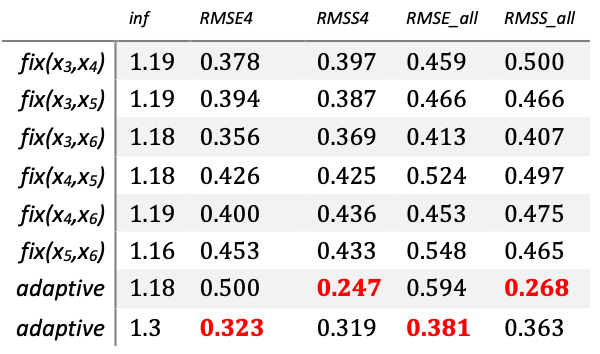

表格里面列出的是同化了不同格点的两个观测后的状态估计结果的RMSE和平均spread，四个目标变量的RMSE，RMSS以及全部变量的都列在里面，同时也加入考虑了预报和分析时刻的RMSE和RMSS。每个实验都通过调整inf系数使得RMSE和RMSS大小相当（此时的RMSE也是最小的）。可以看到，对于两个固定观测点的实验，大多采用1.18上下的inflation。而对于自适应的实验，由于每次同化选择观测的目标是最小化分析误差标准差，集合的离散度下降很快，所以如果采用1.18的inflation只会使RMSS相对太低。当然这个情况下，RMSS都是最小的。然而对于RMSE的减小效果不显著。适当扩大inflation后，可以看到自适应观测的效果，无论是目标变量还是全部变量的RMSE，其结果都是最小的。

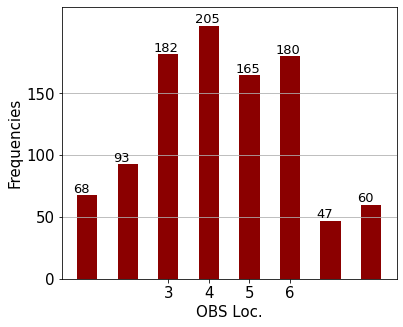

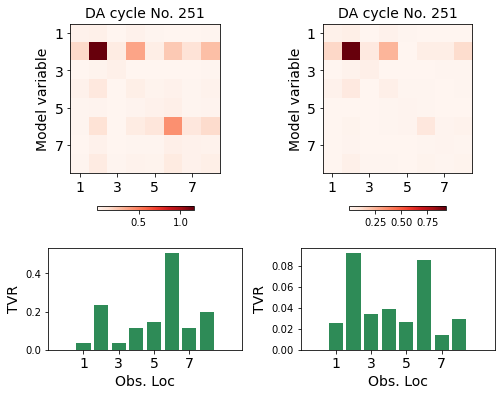

In [20]:
TMP_DAT = np.load(case_dir+'output/se_result_2obsadapt1.18.npz')
Xassim=TMP_DAT['arr_0'];Xspread=TMP_DAT['arr_1']
preassm_mean = TMP_DAT['arr_2'];preassm_std = TMP_DAT['arr_3']
postassm_mean = TMP_DAT['arr_4'];postassm_std = TMP_DAT['arr_5']
preassm_std_inf = TMP_DAT['arr_6'];INDICES = TMP_DAT['arr_7'] 

plt.figure(figsize=(6,5))
bins = np.arange(-0.5,8.5,1)
tmp=plt.hist(INDICES.flatten(),bins,rwidth=0.5,color='DarkRed')
Nloc = np.array(tmp[0],dtype='int')
plt.yticks(np.arange(0,200,50),fontsize=15);plt.ylim(0,220);plt.ylabel('Frequencies',fontsize=15)
plt.xticks(np.arange(2,6),[3,4,5,6],fontsize=15);plt.xlabel('OBS Loc.',fontsize=15)
plt.grid(axis='y')
for a,b in zip(range(8),Nloc):
    plt.text(a-0.35, b+2,'%.2i' % b,fontsize=13)
obs_locs = np.zeros([K,np.max(Nloc)],dtype='int')
for j in range(K):
    obs_locs[j,range(Nloc[j])] = np.argwhere(INDICES==j)[:,0]

DD = np.load(case_dir+'seTVR251_0.npz')
VR1 = DD['arr_0'];tvr1 = DD['arr_1'];
DD = np.load(case_dir+'seTVR251_1.npz')
VR2 = DD['arr_0'];tvr2 = DD['arr_1'];
#plt.savefig(case_dir+'figure2_1.eps',format='eps')

plt.figure(figsize=(8,6))
grid = plt.GridSpec(3, 2, wspace=0.3, hspace=0.1)
plt.subplot(grid[0:2,0])
plt.imshow(VR1, cmap=plt.cm.Reds)
plt.ylabel('Model variable',fontsize=14)
plt.xticks(np.arange(0,8,2),np.arange(1,9,2),fontsize=14);
plt.yticks(np.arange(0,8,2),np.arange(1,9,2),fontsize=14);
plt.title('DA cycle No. 251',fontsize=14)
plt.colorbar(orientation='horizontal',shrink=0.5)
plt.subplot(grid[2,0])
plt.bar(np.arange(1,9),tvr1,width=0.8,fc='seagreen')
plt.xticks(np.arange(1,9,2),np.arange(1,9,2),fontsize=14);
plt.xlabel('Obs. Loc',fontsize=14)
plt.ylabel('TVR',fontsize=14)
plt.xlim(-1,10)
plt.subplot(grid[0:2,1])
plt.imshow(VR2, cmap=plt.cm.Reds)
plt.ylabel('Model variable',fontsize=14)
plt.xticks(np.arange(0,8,2),np.arange(1,9,2),fontsize=14);
plt.yticks(np.arange(0,8,2),np.arange(1,9,2),fontsize=14);
plt.title('DA cycle No. 251',fontsize=14)
plt.colorbar(orientation='horizontal',shrink=0.5)
plt.subplot(grid[2,1])
plt.bar(np.arange(1,9),tvr2,width=0.8,fc='seagreen')
plt.xticks(np.arange(1,9,2),np.arange(1,9,2),fontsize=14);
plt.xlabel('Obs. Loc',fontsize=14)
plt.ylabel('TVR',fontsize=14)
plt.xlim(-1,10)
#plt.savefig(case_dir+'figure2_2.eps',format='eps')

（上述图再加一个求TVR的案例图，图中的每个观测(横轴)对于每个模式变量(纵轴)的方差减小量都一一算出来了，然后再目标区域求和，列在下表中的TVR，可以判定最有效的观测点，并进行同化。同化一个观测之后，再次计算TVR，可以看到第一个观测点的效果考虑进去之后，第二个观测点的TVR数值小很多，可以进一步判定下一个观测点。）在自适应方法（inf=1.3，结果较好的case）中，各个观测点出现的次数如上图，可以发现，$x_4$出现的次数最多，随后是$x_3,x_6,x_5$，这几个点的重要性是比较符合逻辑的，因为目标区域为$x_3$~$x_6$，同化期间的观测自然更能够改进该区域的分析。当然，目标区域外的观测点的重要性也没被排除。
在目标区域之内，大致可以判定$x_4$比$x_5$更重要，从同化的结果也可以看出，含有$x_4$观测点的实验结果的RMSE比含有$x_5$观测的实验结果的RMSE普遍更小一些，当然这个结果是相对的。

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


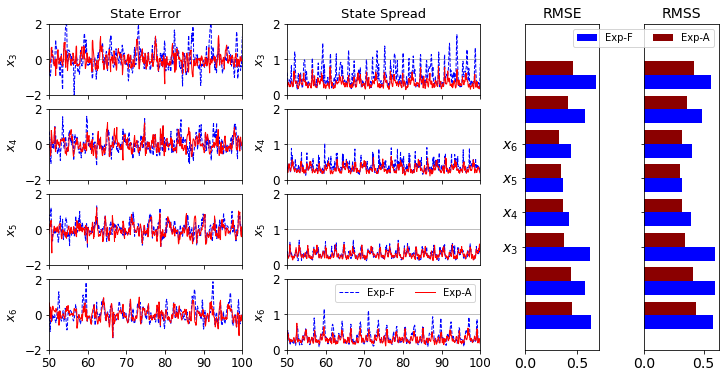

In [21]:
TMP_DAT = np.load(case_dir+'output/se_result_2obs45.npz')
Xassim=TMP_DAT['arr_0'];Xspread=TMP_DAT['arr_1']
Err1 = Xassim-Xu;Spd1 = Xspread
TMP_DAT = np.load(case_dir+'output/se_result_2obsadapt1.3.npz')
Xassim=TMP_DAT['arr_0'];Xspread=TMP_DAT['arr_1']
Err2 = Xassim-Xu;Spd2 = Xspread
RMSE1 = np.sqrt(np.mean(np.square(Err1[range(1000,assim_period)]),axis=0))
RMSE2 = np.sqrt(np.mean(np.square(Err2[range(1000,assim_period)]),axis=0))
RMSS1 = np.sqrt(np.mean(np.square(Spd1[range(1000,assim_period)]),axis=0))
RMSS2 = np.sqrt(np.mean(np.square(Spd2[range(1000,assim_period)]),axis=0))


fig=plt.figure(figsize=(12,6))
grid = plt.GridSpec(4, 6, wspace=0.6, hspace=0.2)

plt.subplot(grid[0,0:2])
plt.plot(np.arange(1000,assim_period)*dt,Err1[1000::,2],'b--',lw=1,label='Exp-F')
plt.plot(np.arange(1000,assim_period)*dt,Err2[1000::,2],'r',lw=1,label='Exp-A')
plt.title('State Error',fontsize=13)
plt.ylabel(r'$x_3$',fontsize=12)
plt.yticks(np.arange(-2,4,2),fontsize=12);plt.ylim(-2,2)
plt.xticks(range(50,105,10),[],fontsize=12);plt.xlim(50,100)
plt.grid(axis='y')
#
plt.subplot(grid[1,0:2])
plt.plot(np.arange(1000,assim_period)*dt,Err1[1000::,3],'b--',lw=1,label='Exp-F')
plt.plot(np.arange(1000,assim_period)*dt,Err2[1000::,3],'r',lw=1,label='Exp-A')
plt.ylabel(r'$x_4$',fontsize=12)
plt.yticks(np.arange(-2,4,2),fontsize=12)
plt.xticks(range(50,105,10),[],fontsize=12);plt.xlim(50,100)

plt.subplot(grid[2,0:2])
plt.plot(np.arange(1000,assim_period)*dt,Err1[1000::,4],'b--',lw=1,label='Exp_F')
plt.plot(np.arange(1000,assim_period)*dt,Err2[1000::,4],'r',lw=1,label='Exp_A')
plt.ylabel(r'$x_5$',fontsize=12)
plt.yticks(np.arange(-2,4,2),fontsize=12)
plt.xticks(range(50,105,10),[],fontsize=12);plt.xlim(50,100)

plt.subplot(grid[3,0:2])
plt.plot(np.arange(1000,assim_period)*dt,Err1[1000::,5],'b--',lw=1,label='Exp_F')
plt.plot(np.arange(1000,assim_period)*dt,Err2[1000::,5],'r',lw=1,label='Exp_A')
plt.ylabel(r'$x_6$',fontsize=12)
plt.yticks(np.arange(-2,4,2),fontsize=12)
plt.xticks(range(50,105,10),fontsize=12);plt.xlim(50,100)

# #
plt.subplot(grid[0,2:4])
plt.plot(np.arange(1000,assim_period)*dt,Spd1[1000::,2],'b--',lw=1,label='Exp_F')
plt.plot(np.arange(1000,assim_period)*dt,Spd2[1000::,2],'r',lw=1,label='Exp_A')
plt.title('State Spread',fontsize=13)
plt.ylabel(r'$x_3$',fontsize=12)
plt.yticks(np.arange(0,3,1),fontsize=12);plt.ylim(0,2)
plt.xticks(range(50,105,10),[],fontsize=12);plt.xlim(50,100)
plt.grid(axis='y')
#
plt.subplot(grid[1,2:4])
plt.plot(np.arange(1000,assim_period)*dt,Spd1[1000::,3],'b--',lw=1,label='Exp-F')
plt.plot(np.arange(1000,assim_period)*dt,Spd2[1000::,3],'r',lw=1,label='Exp-A')
plt.ylabel(r'$x_4$',fontsize=12)
plt.yticks(np.arange(0,3,1),fontsize=12);plt.ylim(0,2)
plt.xticks(range(50,105,10),[],fontsize=12);plt.xlim(50,100)
plt.grid(axis='y')

plt.subplot(grid[2,2:4])
plt.plot(np.arange(1000,assim_period)*dt,Spd1[1000::,4],'b--',lw=1,label='Exp-F')
plt.plot(np.arange(1000,assim_period)*dt,Spd2[1000::,4],'r',lw=1,label='Exp-A')
plt.ylabel(r'$x_5$',fontsize=12)
plt.yticks(np.arange(0,3,1),fontsize=12);plt.ylim(0,2)
plt.xticks(range(50,105,105),[],fontsize=12);plt.xlim(50,100)
plt.grid(axis='y')

plt.subplot(grid[3,2:4])
plt.plot(np.arange(1000,assim_period)*dt,Spd1[1000::,5],'b--',lw=1,label='Exp-F')
plt.plot(np.arange(1000,assim_period)*dt,Spd2[1000::,5],'r',lw=1,label='Exp-A')
plt.ylabel(r'$x_6$',fontsize=12)
plt.yticks(np.arange(0,3,1),fontsize=12);plt.ylim(0,2)
plt.xticks(range(50,105,10),fontsize=12);plt.xlim(50,100)
plt.grid(axis='y');plt.legend(ncol=2)

#
plt.subplot(grid[0:4,4])
plt.barh(np.arange(1,9)-0.2,RMSE1,0.4,fc='blue',label='Exp-F')
plt.barh(np.arange(1,9)+0.2,RMSE2,0.4,fc='DarkRed',label='Exp-A')
plt.ylim(0,9.5)
plt.yticks([3,4,5,6],[r'$x_3$',r'$x_4$',r'$x_5$',r'$x_6$'],fontsize=14)
plt.xticks(fontsize=14)
plt.title('RMSE',fontsize=14)
#
plt.subplot(grid[0:4,5])
plt.barh(np.arange(1,9)-0.2,RMSS1,0.4,fc='Blue',label='Exp-F')
plt.barh(np.arange(1,9)+0.2,RMSS2,0.4,fc='DarkRed',label='Exp-A')
plt.legend(ncol=2)
plt.yticks([3,4,5,6],[],fontsize=14)
plt.xticks(fontsize=14)
plt.title('RMSS',fontsize=14)
plt.ylim(0,9.5)
#plt.savefig(case_dir+'figure3.eps',format='eps')

图中表示了固定点同化实验（Exp_F)和自适应同化实验（Exp_A)的效果差异，其中固定点同化方案同化的是$x_4$和$x_5$的观测。由于$x_4$和$x_5$持续被同化，因此两个实验对于这两个变量的效果差异并不明显，但是对于在Exp_F实验中不被观测到的变量（如$x_3$和$x_6$），Exp_A显然产生了更小的误差值和标准差。而对于目标区域以外的变量，实际上也通过同化得到了更大程度的改进。从RMSE和RMSS两方面都是如此。这也和上面表格中的一致。

### 参数估计实验：

下一步进行参数估计，对于参数化方程（4）的三个参数$b_0$,$b_1$,$b_2$进行估计，因为预设了参数化形式，对于其中的参数进行估计，所以在概念上，也称为在线估计。为了更好地达成估计效果，提高参数-状态的协方差的准确性，先开展一段时间的纯状态估计，达到稳定后再调参数。为方便对比，无论是Exp_F还是Exp_A实验，这段状态估计都先采用固定的观测点(以$x_3$和$x_6$为例)，长度为25个时间单位（或者500模式步，125个同化循环）。打开参数估计之后，再比较自适应或固定观测网的策略。

关于参数的TVR计算方式以下图为例


蓝色框对应的三个变量为参数，评估每个观测点对于参数不确定性的减少量，并进行排序，选择最优观测点。

In [13]:
# In[Parameter estimation with 2 fix obs]
obs_idx_se = np.array([2,4])  # x3 and x5
inf_state = 1.185
obs_dim = 2
#if True:
if not os.path.exists(case_dir+'output/pe_online_2obs.npz'):
    TMP_DAT = np.load(case_dir+'INITENS/INITENS'+str(Ne)+'.npz')
    X0 = TMP_DAT['arr_0'];
    Force0 = F   # constant F but with polynomial function of X
    pC0 = np.array([-0.1,1,0.1]);pCstd=np.array([0.3,1,0.5])
    PCs0 = np.ones([Ne,3])
    for j in range(Ne):      # intial perturbation of coefficients
        PCs0[j] = pC0+pCstd*np.random.randn(3)    
    H_mat_ext = np.eye(K+3);H_mat_ext = H_mat_ext[range(K)] # H extension
    Ens = X0; PCs = PCs0; 
    Ens2 = np.zeros_like(Ens)
    ana_steps = assim_period//obs_every_n_steps
    Xassim_ana = np.zeros([ana_steps,Ne,K])
    PCassim_ana = np.zeros([ana_steps,Ne,3])
    Xassim = np.zeros_like(Xu)
    Xspread = np.zeros_like(Xassim)
    preassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    preassm_std = np.zeros_like(preassm_mean)
    preassm_std_inf = np.zeros_like(preassm_mean)
    postassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    postassm_std = np.zeros_like(postassm_mean)
    #
    LOC_MAT = np.ones([K,K])
    LOC_MAT_P = np.ones([3,K])
    LOC_MAT_ext = np.concatenate([LOC_MAT,LOC_MAT_P],axis=0)
    # se only with large inflation
    se_only_period = 500; # a period of only state estimation
    for t in range(se_only_period):
        for n in range(Ne):      # integrate
            Ens2[n]=L96para_adv_1step(Ens[n],dt,Force0,pC0);
        if t%obs_every_n_steps==0:    # if assim
            tassim = t//obs_every_n_steps;
            obs_in = OBS[tassim]
            preassm_mean[tassim] = np.mean(Ens2,axis=0)
            preassm_std[tassim] = np.std(Ens2,axis=0)
            # inflation
            ens_mean = np.mean(Ens2,axis=0)
            for n in range(Ne):
                Ens2[n] = inf_state*(Ens2[n]-ens_mean)+ens_mean
            preassm_std_inf[tassim] = np.std(Ens2,axis=0)
            for idx in obs_idx_se:
                H_i = H_mat[idx,:]
                Ens2 = eakf_analysis_1obs(Ens2,obs_in[idx],obs_error_var,H_i,LOC_MAT[:,idx],H_op);    
            postassm_mean[tassim] = np.mean(Ens2,axis=0)
            postassm_std[tassim] = np.std(Ens2,axis=0)
            Xassim_ana[tassim] = Ens2
        else:
            pass
        # mean and std
        Xassim[t] = np.mean(Ens2, axis=0);
        Xspread[t] = np.std(Ens2,axis=0);   
        Ens = Ens2;
    # activate PE 
    # with smaller inflation
    inf_state = 1.03;inf_para = 1.03
    for t in range(se_only_period,assim_period):
        for n in range(Ne):      # integration with parameterized model
            Ens2[n]=L96para_adv_1step(Ens[n],dt,Force0,PCs[n]);
        if t%obs_every_n_steps==0:    # if assim
            tassim = t//obs_every_n_steps;
            obs_in = OBS[tassim]
            preassm_mean[tassim] = np.mean(Ens2,axis=0)
            preassm_std[tassim] = np.std(Ens2,axis=0)
            # inflation for state and parameter
            ens_mean = np.mean(Ens2,axis=0)
            for n in range(Ne):
                Ens2[n] = inf_state*(Ens2[n]-ens_mean)+ens_mean
            preassm_std_inf[tassim] = np.std(Ens2,axis=0)
            pc_mean = np.mean(PCs,axis=0)
            for n in range(Ne):
                PCs[n] = inf_para*(PCs[n]-pc_mean)+pc_mean
            Ens_ext = np.concatenate([Ens2,PCs],axis=1)    # augment state with parameter for joint estimation
            #Ens_ext= eakf_analysis(Ens_ext,obs_in,obs_error_var,H_mat_ext,LOC_MAT_ext,H_op);
            
            for i in obs_idx_se:                
                H_i = H_mat_ext[i,:]
                Ens_ext = eakf_analysis_1obs(Ens_ext,obs_in[i],obs_error_var,H_i,LOC_MAT_ext[:,idx],H_op);    
            Ens2 = Ens_ext[:,range(K)]
            PCs = Ens_ext[:,range(K,K+3)]
            PCassim_ana[tassim] = PCs
            Xassim_ana[tassim] = Ens2
            postassm_mean[tassim] = np.mean(Ens2,axis=0)
            postassm_std[tassim] = np.std(Ens2,axis=0)
        else:
            pass   
        # mean and std
        Xassim[t] = np.mean(Ens2, axis=0);
        Xspread[t] = np.std(Ens2,axis=0);   
        Ens = Ens2;
    np.savez(case_dir+'output/pe_online_2obs.npz',Xassim,Xspread,Xassim_ana,\
              PCassim_ana,preassm_mean,preassm_std,postassm_mean,postassm_std,\
                  preassm_std_inf,INDICES)
else:
    TMP_DAT = np.load(case_dir+'output/pe_online_2obs.npz')
    Xassim = TMP_DAT['arr_0'];Xspread = TMP_DAT['arr_1']
    Xassim_ana = TMP_DAT['arr_2'];PCassim_ana = TMP_DAT['arr_3']
    preassm_mean = TMP_DAT['arr_4'];preassm_std = TMP_DAT['arr_5']
    postassm_mean = TMP_DAT['arr_6'];postassm_std = TMP_DAT['arr_7']
    preassm_std_inf = TMP_DAT['arr_8'];

RMSE = np.sqrt(np.mean(np.square(Xassim-Xu),axis=1))
RMSS = np.sqrt(np.mean(np.square(Xspread),axis=1))

#In[plot state estimation]
# plt.figure(figsize=(12,9))
# for j in range(8):
#     plt.subplot(5,2,j+1)
#     plt.plot(Xu[range(2000),j],'k--',lw=2,label='true')
#     plt.plot(Xassim[range(2000),j],color='seagreen',lw=2,label='SE')
#     if j in obs_idx:
#         plt.plot(np.arange(0,2000,obs_every_n_steps),OBS[range(2000//obs_every_n_steps),j],'r.',ms=8,mew=2,label='obs')
#     plt.ylabel(r'$x_'+str(j+1)+'$',fontsize=15)
#     plt.grid(axis='y')
#     if j%2==0:
#         plt.xlim(0,1000)
#         plt.xticks(np.arange(0,1000,250),fontsize=15);
#         plt.yticks(np.arange(-2.5,10,2.5),fontsize=15)
#     else:
#         plt.xlim(1000,2000)
#         plt.xticks(np.arange(1000,2000,250),fontsize=15);plt.yticks(fontsize=15)
#         plt.yticks(np.arange(-2.5,10,2.5),[],fontsize=15)    
#     if j==0:
#         plt.title('parameter estimation'.capitalize(),fontsize=15)
#         plt.legend(fontsize=12,ncol=3)
# plt.tight_layout()
# plt.subplots_adjust(hspace = 0.2,wspace=0.1)
# plt.subplot(5,1,5)
# plt.plot(RMSE,'r',lw=2,label='RMSE')
# plt.plot(RMSS,'k',lw=2,label='RMSS')
# plt.xlim(0,2000);plt.xticks(np.arange(0,2000,250),fontsize=15);
# plt.ylim(0,1.2);plt.yticks(np.arange(0,1.2,0.2),fontsize=15)
# plt.grid(axis='y')
# plt.legend(fontsize=12,ncol=2,loc=5)
# plt.text(500,1,'average RMSE=%.3f'%np.mean(RMSE[range(1000,2000)])+',average RMSS=%.3f'%np.mean(RMSS[range(1000,2000)])+',inf: '+str(inf_state),fontsize=15)
# #In[p prepost]
# RMSE_preassm = np.sqrt(np.mean(np.square(preassm_mean-OBS),axis=1))
# RMSS_preassm = np.sqrt(np.mean(np.square(preassm_std),axis=1))
# RMSS_preassm_inf = np.sqrt(np.mean(np.square(preassm_std_inf),axis=1))
# RMSE_postassm = np.sqrt(np.mean(np.square(postassm_mean-OBS),axis=1))
# RMSS_postassm = np.sqrt(np.mean(np.square(postassm_std),axis=1))

# plt.figure(figsize=(15,6))
# plt.subplot(2,1,1)
# plt.plot(range(0,assim_period,obs_every_n_steps),RMSE_preassm,'r',label='preassim')
# plt.plot(range(0,assim_period,obs_every_n_steps),RMSE_postassm,'b',label='postassim')
# plt.legend(fontsize=15,loc=1)
# plt.xticks(np.arange(0,2000,250),[],fontsize=15);plt.xlim(0,2000)
# plt.yticks(np.arange(0,2,0.5),fontsize=15);plt.ylabel('RMSE',fontsize=15)
# plt.ylim(0,1.5);
# plt.text(50,1.3,'mean of last 1000 model step, inf: '+str(inf_state),fontsize=15)
# plt.text(50,1.1,'preassim: %.3f' %np.mean(RMSE_preassm[range(250,500)])  \
#           +', postassim: %.3f' %np.mean(RMSE_postassm[range(250,500)]),fontsize=15)
# plt.subplot(2,1,2)
# plt.plot(range(0,assim_period,obs_every_n_steps),RMSS_preassm,'r--',label='preassim')
# plt.plot(range(0,assim_period,obs_every_n_steps),RMSS_preassm_inf,'--',color='Orange',label='preassim_inf')
# plt.plot(range(0,assim_period,obs_every_n_steps),RMSS_postassm,'b--',label='postassim')
# plt.legend(ncol=2,fontsize=15)
# plt.xticks(np.arange(0,2000,250),fontsize=15);plt.xlim(0,2000)
# plt.yticks(np.arange(0,2,0.5),fontsize=15);plt.ylim(0,1.5)
# plt.grid(axis='y');plt.ylabel('RMSS',fontsize=15)
# plt.text(50,1.3,'mean of last 1000 model step',fontsize=15)
# plt.text(50,1.1,'preassim: %.3f' %np.mean(RMSS_preassm[range(250,500)])  \
#           +', postassim: %.3f' %np.mean(RMSS_postassm[range(250,500)]),fontsize=15)
# #In[fitting the parameters with truth or estimated]
# Yassim_ana = np.zeros_like(Xassim_ana)
# for j in range(125,500):
#     for n in range(Ne):
#         Yassim_ana[j,n] = np.polyval(PCassim_ana[j,n],Xassim_ana[j,n]) 
# #
# meanPara = np.mean(Yassim_ana,axis=1)
# meanXana = np.mean(Xassim_ana,axis=1)
# plt.figure(figsize=(8,4))
# plt.subplot(1,2,1)
# plt.scatter(Xu[range(600,2000,10)],Para_true[range(600,2000,10)],s=1)
# plt.plot(xtt,gU(xtt),'k--',lw=3)
# plt.ylim(-5,8);plt.xlim(-3,9)
# for j in range(len(z)):
#     plt.text(-1+4*j,6,r'$b_'+str(j)+'$=%.3f'%z[2-j]+',',fontsize=12)
# plt.ylabel(r'$\frac{hc}{b}\sum_{j=1}^{J} Z_{j,k}$',fontsize=15);plt.xlabel(r'$X_j$',fontsize=15)
# plt.xticks(fontsize=15);plt.yticks(fontsize=15)
# plt.title('Truth',fontsize=15);
# plt.subplots_adjust(wspace=0.4,hspace=0)
# plt.subplot(1,2,2)
# plt.scatter(meanXana[range(150,500)],meanPara[range(150,500)],s=1,c='r')
# plt.ylim(-5,8);plt.xlim(-3,9)
# plt.ylabel(r'y=$g_U(x)$',fontsize=15);plt.xlabel(r'$X_{assim}$',fontsize=15)
# plt.xticks(fontsize=15);plt.yticks(fontsize=15)
# plt.title('Analysis',fontsize=15)
# #In[plot PE errors and RMSE]
# meanPara = np.mean(Yassim_ana,axis=1)
# plt.figure(figsize=(10,10))
# for j in range(8):
#     plt.subplot(5,2,j+1)
#     plt.plot(range(0,assim_period),Para_true[:,j],'y',label=r'from $Z_{true}$')
#     plt.plot(range(0,assim_period,obs_every_n_steps),meanPara[:,j],'b',label='estimated mean')
#     plt.xlim(250,1000);plt.ylim(-5,10)
#     plt.ylabel(r'$X_'+str(j+1)+'$',fontsize=14)
#     if j >5:
#         plt.xticks(range(250,1250,250),fontsize=15)
#     else:
#         plt.xticks(range(250,1250,250),[],fontsize=15)
#     if j<2:
#         plt.title('Parameterized coupling term',fontsize=13)
#         plt.legend(ncol=2,fontsize=12)
#     if j%2==0:
#         plt.yticks(np.arange(-5,15,5),fontsize=15)
#     else:
#         plt.yticks(np.arange(-5,15,5),[],fontsize=15)
# plt.tight_layout()
# plt.subplots_adjust(hspace = 0.4,wspace=0.2)#
# para_rmse = np.sqrt(np.mean(np.square(Para_true[range(0,assim_period,obs_every_n_steps)]-meanPara) ,axis=1))
# para_rmse[range(125)]=np.nan
# plt.subplot(5,1,5)
# plt.plot(range(0,assim_period,obs_every_n_steps),para_rmse,'r-.')
# plt.xlim(0,2000);
# plt.xticks(range(500,2000,200),fontsize=15)
# plt.grid();plt.ylabel('RMSE',fontsize=15)
# plt.yticks([0,1,2],fontsize=15)
# plt.ylim(0,2.5)
# #  In[plot parameters]
# PCmean = np.mean(PCassim_ana,axis=1)
# PCstd = np.std(PCassim_ana,axis=1)
# for j in range(125):
#     PCmean[j]=pC0
# plt.figure(figsize=(12,6))
# plt.subplot(2,1,1)
# plt.plot(range(0,assim_period,obs_every_n_steps),PCmean[:,0],'r',label=r'$a_2$')
# plt.plot(range(0,assim_period,obs_every_n_steps),PCmean[:,1],'b',label=r'$a_1$')
# plt.plot(range(0,assim_period,obs_every_n_steps),PCmean[:,2],'g',label=r'$a_0$')
# plt.plot(range(0,assim_period),pC0[0]*np.ones(assim_period),'r--')
# plt.plot(range(0,assim_period),pC0[1]*np.ones(assim_period),'b--')
# plt.plot(range(0,assim_period),pC0[2]*np.ones(assim_period),'g--')
# plt.legend(ncol=3,fontsize=15,loc=2)
# plt.xlim(0,200);plt.xticks([0,500,1000,1500,2000],fontsize=15)
# plt.ylim(-1,2);plt.yticks([-1,0,1,2],fontsize=15)
# plt.grid(axis='y');plt.ylabel('Para. Mean',fontsize=15)
# plt.subplot(2,1,2)
# plt.plot(range(0,assim_period,obs_every_n_steps),PCstd[:,0],'r',label=r'$a_2$')
# plt.plot(range(0,assim_period,obs_every_n_steps),PCstd[:,1],'b',label=r'$a_1$')
# plt.plot(range(0,assim_period,obs_every_n_steps),PCstd[:,2],'g',label=r'$a_0$')
# plt.xlim(0,2000);plt.xticks([0,500,1000,1500,2000],fontsize=15)
# plt.ylim(-0.1,0.8);plt.yticks(np.arange(0,0.8,0.2),fontsize=15)
# plt.grid(axis='y');plt.ylabel('Para. STD',fontsize=15)
# plt.xlabel('model steps',fontsize=15)


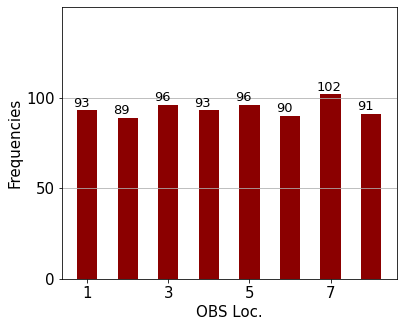

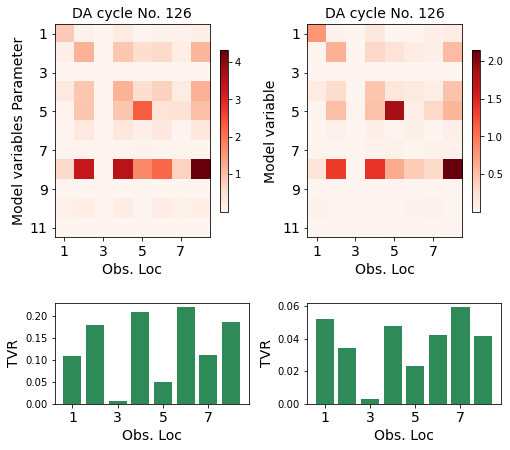

In [34]:
# In[Parameter estimation with 2 adaptive obs]
obs_idx_se = np.array([2,4])
inf_state = 1.185
obs_dim = 2
INDICES = np.zeros([500,2])
#if True:
if not os.path.exists(case_dir+'output/pe_online_2obs_adp.npz'):
    TMP_DAT = np.load(case_dir+'INITENS/INITENS'+str(Ne)+'.npz')
    X0 = TMP_DAT['arr_0'];
    Force0 = F   # constant F but with polynomial function of X
    pC0 = np.array([-0.1,1,0.1]);pCstd=np.array([0.3,1,0.5])
    PCs0 = np.ones([Ne,3])
    for j in range(Ne):      # intial perturbation of coefficients
        PCs0[j] = pC0+pCstd*np.random.randn(3)    
    H_mat_ext = np.eye(K+3);H_mat_ext = H_mat_ext[range(K)] # H extension
    Ens = X0; PCs = PCs0; 
    Ens2 = np.zeros_like(Ens)
    ana_steps = assim_period//obs_every_n_steps
    Xassim_ana = np.zeros([ana_steps,Ne,K])
    PCassim_ana = np.zeros([ana_steps,Ne,3])
    Xassim = np.zeros_like(Xu)
    Xspread = np.zeros_like(Xassim)
    preassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    preassm_std = np.zeros_like(preassm_mean)
    preassm_std_inf = np.zeros_like(preassm_mean)
    postassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    postassm_std = np.zeros_like(postassm_mean)
    #
    LOC_MAT = np.ones([K,K])
    LOC_MAT_P = np.ones([3,K])
    LOC_MAT_ext = np.concatenate([LOC_MAT,LOC_MAT_P],axis=0)
    # se only with large inflation
    se_only_period = 500; # a period of only state estimation
    for t in range(se_only_period):
        for n in range(Ne):      # integrate
            Ens2[n]=L96para_adv_1step(Ens[n],dt,Force0,pC0);
        if t%obs_every_n_steps==0:    # if assim
            tassim = t//obs_every_n_steps;
            obs_in = OBS[tassim]
            preassm_mean[tassim] = np.mean(Ens2,axis=0)
            preassm_std[tassim] = np.std(Ens2,axis=0)
            # inflation
            ens_mean = np.mean(Ens2,axis=0)
            for n in range(Ne):
                Ens2[n] = inf_state*(Ens2[n]-ens_mean)+ens_mean
            preassm_std_inf[tassim] = np.std(Ens2,axis=0)
            INDICES[tassim] = obs_idx_se
            for idx in obs_idx_se:
                H_i = H_mat[idx,:]
                Ens2 = eakf_analysis_1obs(Ens2,obs_in[idx],obs_error_var,H_i,LOC_MAT[:,idx],H_op);    
            postassm_mean[tassim] = np.mean(Ens2,axis=0)
            postassm_std[tassim] = np.std(Ens2,axis=0)
            Xassim_ana[tassim] = Ens2
        else:
            pass
        # mean and std
        Xassim[t] = np.mean(Ens2, axis=0);
        Xspread[t] = np.std(Ens2,axis=0);   
        Ens = Ens2;
    # activate PE 
    # with smaller inflation
    inf_state = 1.03;inf_para = 1.03
    for t in range(se_only_period,assim_period):
        for n in range(Ne):      # integration with parameterized model
            Ens2[n]=L96para_adv_1step(Ens[n],dt,Force0,PCs[n]);
        if t%obs_every_n_steps==0:    # if assim
            tassim = t//obs_every_n_steps;
            obs_in = OBS[tassim]
            preassm_mean[tassim] = np.mean(Ens2,axis=0)
            preassm_std[tassim] = np.std(Ens2,axis=0)
            # inflation for state and parameter
            ens_mean = np.mean(Ens2,axis=0)
            for n in range(Ne):
                Ens2[n] = inf_state*(Ens2[n]-ens_mean)+ens_mean
            preassm_std_inf[tassim] = np.std(Ens2,axis=0)
            pc_mean = np.mean(PCs,axis=0)
            for n in range(Ne):
                PCs[n] = inf_para*(PCs[n]-pc_mean)+pc_mean
            Ens_ext = np.concatenate([Ens2,PCs],axis=1)    # augment state with parameter for joint estimation
            #Ens_ext= eakf_analysis(Ens_ext,obs_in,obs_error_var,H_mat_ext,LOC_MAT_ext,H_op);
            opt_idx=[]
#             if tassim ==126 or tassim==201:
#                 plt.figure(figsize=(8,6))
#                 grid = plt.GridSpec(3, 2, wspace=0.3, hspace=0.3)
            for i in range(obs_dim):
                VR = comp_vr(Ens_ext, obs_error_var, H_op, H_mat_ext)
                tvr = np.sum(VR[8::,:],axis=0)
                idx1 = max_index(tvr, opt_idx)
                opt_idx.append(idx1)
                H_i = H_mat_ext[idx1,:]
                if tassim==126:
                    np.savez(case_dir+'peTVR126_'+str(i)+'.npz',VR,tvr)

                #################
                Ens_ext = eakf_analysis_1obs(Ens_ext,obs_in[idx1],obs_error_var,H_i,LOC_MAT_ext[:,idx],H_op);    
            INDICES[tassim]=opt_idx
            Ens2 = Ens_ext[:,range(K)]
            PCs = Ens_ext[:,range(K,K+3)]
            PCassim_ana[tassim] = PCs
            Xassim_ana[tassim] = Ens2
            postassm_mean[tassim] = np.mean(Ens2,axis=0)
            postassm_std[tassim] = np.std(Ens2,axis=0)
        else:
            pass   
        # mean and std
        Xassim[t] = np.mean(Ens2, axis=0);
        Xspread[t] = np.std(Ens2,axis=0);   
        Ens = Ens2;
    np.savez(case_dir+'output/pe_online_2obs_adp.npz',Xassim,Xspread,Xassim_ana,\
              PCassim_ana,preassm_mean,preassm_std,postassm_mean,postassm_std,\
                  preassm_std_inf,INDICES)
else:
    TMP_DAT = np.load(case_dir+'output/pe_online_2obs_adp.npz')
    Xassim = TMP_DAT['arr_0'];Xspread = TMP_DAT['arr_1']
    Xassim_ana = TMP_DAT['arr_2'];PCassim_ana = TMP_DAT['arr_3']
    preassm_mean = TMP_DAT['arr_4'];preassm_std = TMP_DAT['arr_5']
    postassm_mean = TMP_DAT['arr_6'];postassm_std = TMP_DAT['arr_7']
    preassm_std_inf = TMP_DAT['arr_8'];INDICES = TMP_DAT['arr_9']

RMSE = np.sqrt(np.mean(np.square(Xassim-Xu),axis=1))
RMSS = np.sqrt(np.mean(np.square(Xspread),axis=1))

# In[plt bins]
INDICESPE = INDICES[125::]
plt.figure(figsize=(6,5))
bins = np.arange(-0.5,8.5,1)
tmp=plt.hist(INDICESPE.flatten(),bins,rwidth=0.5,color='DarkRed')
Nloc = np.array(tmp[0],dtype='int')
plt.yticks(np.arange(0,150,50),fontsize=15);plt.ylim(0,150);plt.ylabel('Frequencies',fontsize=15)
plt.xticks(np.arange(0,8,2),np.arange(1,9,2),fontsize=15);plt.xlabel('OBS Loc.',fontsize=15)
plt.grid(axis='y')
for a,b in zip(range(8),Nloc):
    plt.text(a-0.35, b+2,'%.2i' % b,fontsize=13)
obs_locs = np.zeros([K,np.max(Nloc)],dtype='int')
for j in range(K):
    obs_locs[j,range(Nloc[j])] = np.argwhere(INDICESPE==j)[:,0]
#plt.savefig(case_dir+'figure4_2.eps',format='eps') 

# In[plt tvrs]
DD = np.load(case_dir+'peTVR126_0.npz')
VR1 = DD['arr_0'];tvr1 = DD['arr_1'];
DD = np.load(case_dir+'peTVR126_1.npz')
VR2 = DD['arr_0'];tvr2 = DD['arr_1'];

plt.figure(figsize=(8,8))
grid = plt.GridSpec(4, 2, wspace=0.3, hspace=0.1)
plt.subplot(grid[0:3,0])
plt.imshow(VR1, cmap=plt.cm.Reds)
plt.ylabel('Model variables Parameter',fontsize=14)
plt.xlabel('Obs. Loc',fontsize=14)
plt.xticks(np.arange(0,8,2),np.arange(1,9,2),fontsize=14);
plt.yticks(np.arange(0,12,2),np.arange(1,13,2),fontsize=14);
plt.title('DA cycle No. 126',fontsize=14)
plt.colorbar(orientation='vertical',shrink=0.5)
plt.subplot(grid[3,0])
plt.bar(np.arange(0,8),tvr1,width=0.8,fc='seagreen')
plt.xticks(np.arange(0,8,2),np.arange(1,9,2),fontsize=14);
plt.ylabel('TVR',fontsize=14)  
plt.xlabel('Obs. Loc',fontsize=14)
plt.subplot(grid[0:3,1])
plt.imshow(VR2, cmap=plt.cm.Reds)
plt.ylabel('Model variable',fontsize=14)
plt.xlabel('Obs. Loc',fontsize=14)
plt.xticks(np.arange(0,8,2),np.arange(1,9,2),fontsize=14);
plt.yticks(np.arange(0,12,2),np.arange(1,13,2),fontsize=14);
plt.title('DA cycle No. 126',fontsize=14)
plt.colorbar(orientation='vertical',shrink=0.5)
plt.subplot(grid[3,1])
plt.bar(np.arange(0,8),tvr2,width=0.8,fc='seagreen')
plt.xticks(np.arange(0,8,2),np.arange(1,9,2),fontsize=14);
plt.ylabel('TVR',fontsize=14) 
plt.xlabel('Obs. Loc',fontsize=14)
#plt.savefig(case_dir+'figure4_1.eps',format='eps')


#  In[plot state estimation]
# plt.figure(figsize=(12,9))
# for j in range(8):
#     plt.subplot(5,2,j+1)
#     plt.plot(Xu[range(2000),j],'k--',lw=2,label='true')
#     plt.plot(Xassim[range(2000),j],color='seagreen',lw=2,label='SE')
#     obs_idxj = obs_locs[j,range(Nloc[j])]
#     plt.plot(Nt*obs_idxj,OBS[obs_idxj,j],'r.',ms=8,lw=2,label='obs')
#     plt.ylabel(r'$x_'+str(j+1)+'$',fontsize=15)
#     plt.grid(axis='y')
#     if j%2==0:
#         plt.xlim(0,1000)
#         plt.xticks(np.arange(0,1000,250),fontsize=15);
#         plt.yticks(np.arange(-2.5,10,2.5),fontsize=15)
#     else:
#         plt.xlim(1000,2000)
#         plt.xticks(np.arange(1000,2000,250),fontsize=15);plt.yticks(fontsize=15)
#         plt.yticks(np.arange(-2.5,10,2.5),[],fontsize=15)    
#     if j==0:
#         plt.title('parameter estimation'.capitalize(),fontsize=15)
#         plt.legend(fontsize=12,ncol=3)
# plt.tight_layout()
# plt.subplots_adjust(hspace = 0.2,wspace=0.1)
# plt.subplot(5,1,5)
# plt.plot(RMSE,'r',lw=2,label='RMSE')
# plt.plot(RMSS,'k',lw=2,label='RMSS')
# plt.xlim(0,2000);plt.xticks(np.arange(0,2000,250),fontsize=15);
# plt.ylim(0,0.8);plt.yticks(np.arange(0,0.8,0.2),fontsize=15)
# plt.grid(axis='y')
# plt.legend(fontsize=12,ncol=2,loc=5)
# plt.text(500,0.66,'average RMSE=%.3f'%np.mean(RMSE[range(1000,2000)])+',average RMSS=%.3f'%np.mean(RMSS[range(1000,2000)])+',inf: '+str(inf_state),fontsize=15)
# #In[p prepost]
# RMSE_preassm = np.sqrt(np.mean(np.square(preassm_mean-OBS),axis=1))
# RMSS_preassm = np.sqrt(np.mean(np.square(preassm_std),axis=1))
# RMSS_preassm_inf = np.sqrt(np.mean(np.square(preassm_std_inf),axis=1))
# RMSE_postassm = np.sqrt(np.mean(np.square(postassm_mean-OBS),axis=1))
# RMSS_postassm = np.sqrt(np.mean(np.square(postassm_std),axis=1))

可以看出，对于参数估计，每个观测点出现的频次差不多。

<ipython-input-35-bcc10338c023>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx,yy,Xu[range(500,900,4)].T,cmap=pltcmp);plt.clim(-5,5)
<ipython-input-35-bcc10338c023>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xxx,yyy,Ytrue[range(5000,9000,40)].T,cmap=pltcmp);plt.clim(-0.5,0.5)


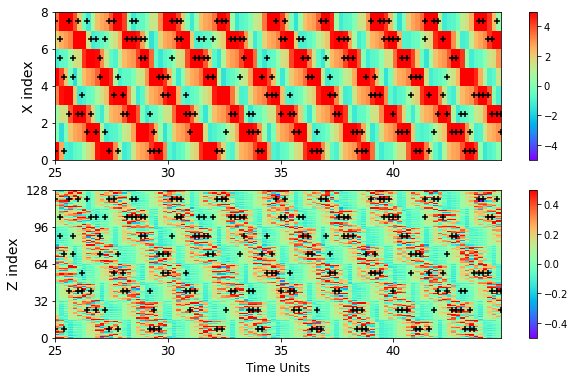

In [35]:
xx,yy = np.meshgrid(range(500,900,4),range(0,9))
pltcmp = plt.cm.rainbow
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.pcolormesh(xx,yy,Xu[range(500,900,4)].T,cmap=pltcmp);plt.clim(-5,5)
plt.colorbar()
plt.ylabel('X index',fontsize=14);plt.yticks([0,2,4,6,8],fontsize=12)
plt.scatter(range(500,900,4),INDICES[range(125,225),0]+0.5,s=30,marker='+',c='black')
plt.scatter(range(500,900,4),INDICES[range(125,225),1]+0.5,s=30,marker='+',c='black')
plt.xticks(range(500,900,100),range(25,45,5),fontsize=12)
plt.subplot(2,1,2)
xxx,yyy = np.meshgrid(range(5000,9000,40),range(0,8*16))
plt.pcolormesh(xxx,yyy,Ytrue[range(5000,9000,40)].T,cmap=pltcmp);plt.clim(-0.5,0.5)
plt.colorbar()
plt.ylabel('Z index',fontsize=14);plt.yticks([0,32,64,96,128],fontsize=12);plt.ylim(0,128)
plt.scatter(range(5000,9000,40),INDICES[range(125,225),0]*16+8,s=30,marker='+',c='black')
plt.scatter(range(5000,9000,40),INDICES[range(125,225),1]*16+8,s=30,marker='+',c='black')
plt.xticks(range(5000,9000,1000),range(25,45,5),fontsize=12)
plt.xlabel('Time Units',fontsize=12)
#plt.savefig(case_dir+'figure5.eps',format='eps')

图中画了第500步(参数估计打开)开始的100个同化循环，可以发现最优观测点的位置很大程度上和模式变量值的较大值区一致。X变量数值较大的区域，是Z变量的活跃区，其数值变率较大。所以显然这些区域对应的参数化误差较大，类似地，参数的不确定性较大。

下面跑一个对照性SE，对比自适应和固定点的PE

In [37]:
# In[State estimation with 2 fix obs]
obs_idx_se = np.array([2,4])  # x3 and x5
inf_state = 1.185
obs_dim = 2
#if True:
if not os.path.exists(case_dir+'output/se_2obs_cmp.npz'):
    TMP_DAT = np.load(case_dir+'INITENS/INITENS'+str(Ne)+'.npz')
    X0 = TMP_DAT['arr_0'];
    Force0 = F   # constant F but with polynomial function of X
    pC0 = np.array([-0.1,1,0.1]);pCstd=np.array([0.3,1,0.5])
    PCs0 = np.ones([Ne,3])
    for j in range(Ne):      # intial perturbation of coefficients
        PCs0[j] = pC0+pCstd*np.random.randn(3)    
    H_mat_ext = np.eye(K+3);H_mat_ext = H_mat_ext[range(K)] # H extension
    Ens = X0; PCs = PCs0; 
    Ens2 = np.zeros_like(Ens)
    ana_steps = assim_period//obs_every_n_steps
    Xassim_ana = np.zeros([ana_steps,Ne,K])
    PCassim_ana = np.zeros([ana_steps,Ne,3])
    Xassim = np.zeros_like(Xu)
    Xspread = np.zeros_like(Xassim)
    preassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    preassm_std = np.zeros_like(preassm_mean)
    preassm_std_inf = np.zeros_like(preassm_mean)
    postassm_mean = np.zeros([assim_period//obs_every_n_steps,K])
    postassm_std = np.zeros_like(postassm_mean)
    #
    LOC_MAT = np.ones([K,K])
    LOC_MAT_P = np.ones([3,K])
    LOC_MAT_ext = np.concatenate([LOC_MAT,LOC_MAT_P],axis=0)
    # se only with large inflation
    for t in range(assim_period):
        for n in range(Ne):      # integrate
            Ens2[n]=L96para_adv_1step(Ens[n],dt,Force0,pC0);
        if t%obs_every_n_steps==0:    # if assim
            tassim = t//obs_every_n_steps;
            obs_in = OBS[tassim]
            preassm_mean[tassim] = np.mean(Ens2,axis=0)
            preassm_std[tassim] = np.std(Ens2,axis=0)
            # inflation
            ens_mean = np.mean(Ens2,axis=0)
            for n in range(Ne):
                Ens2[n] = inf_state*(Ens2[n]-ens_mean)+ens_mean
            preassm_std_inf[tassim] = np.std(Ens2,axis=0)
            for idx in obs_idx_se:
                H_i = H_mat[idx,:]
                Ens2 = eakf_analysis_1obs(Ens2,obs_in[idx],obs_error_var,H_i,LOC_MAT[:,idx],H_op);    
            postassm_mean[tassim] = np.mean(Ens2,axis=0)
            postassm_std[tassim] = np.std(Ens2,axis=0)
            Xassim_ana[tassim] = Ens2
        else:
            pass
        # mean and std
        Xassim[t] = np.mean(Ens2, axis=0);
        Xspread[t] = np.std(Ens2,axis=0);   
        Ens = Ens2;
    np.savez(case_dir+'output/se_2obs_cmp.npz',Xassim,Xspread,Xassim_ana,\
              PCassim_ana,preassm_mean,preassm_std,postassm_mean,postassm_std,\
                  preassm_std_inf,INDICES)
else:
    TMP_DAT = np.load(case_dir+'output/se_2obs_cmp.npz')
    Xassim = TMP_DAT['arr_0'];Xspread = TMP_DAT['arr_1']
    Xassim_ana = TMP_DAT['arr_2'];PCassim_ana = TMP_DAT['arr_3']
    preassm_mean = TMP_DAT['arr_4'];preassm_std = TMP_DAT['arr_5']
    postassm_mean = TMP_DAT['arr_6'];postassm_std = TMP_DAT['arr_7']
    preassm_std_inf = TMP_DAT['arr_8'];

RMSE = np.sqrt(np.mean(np.square(Xassim-Xu),axis=1))
RMSS = np.sqrt(np.mean(np.square(Xspread),axis=1))

以下画图评估参数估计结果。

In [38]:
TMP_DAT = np.load(case_dir+'output/pe_online_2obs.npz')
Xassim_ana = TMP_DAT['arr_2'];PCassim_ana = TMP_DAT['arr_3']
Yassim_ana = np.zeros_like(Xassim_ana)
for j in range(125):
    for n in range(Ne):
        Yassim_ana[j,n]= np.polyval(pC0,Xassim_ana[j,n])     
for j in range(125,500):
    for n in range(Ne):
        Yassim_ana[j,n] = np.polyval(PCassim_ana[j,n],Xassim_ana[j,n]) 
meanPara1 = np.mean(Yassim_ana,axis=1)
meanXana1 = np.mean(Xassim_ana,axis=1)
S11 = np.std(Yassim_ana,axis=1)
PCa1 = PCassim_ana
#
TMP_DAT = np.load(case_dir+'output/pe_online_2obs_adp.npz')
Xassim_ana = TMP_DAT['arr_2'];PCassim_ana = TMP_DAT['arr_3']
Yassim_ana = np.zeros_like(Xassim_ana)
for j in range(125):
    for n in range(Ne):
        Yassim_ana[j,n]= np.polyval(pC0,Xassim_ana[j,n])  
for j in range(125,500):
    for n in range(Ne):
        Yassim_ana[j,n] = np.polyval(PCassim_ana[j,n],Xassim_ana[j,n]) 
meanPara2 = np.mean(Yassim_ana,axis=1)
meanXana2 = np.mean(Xassim_ana,axis=1)
S12 = np.std(Yassim_ana,axis=1)
PCa2 = PCassim_ana
P11 = Para_true[range(0,assim_period,obs_every_n_steps)]-meanPara1
P12 = Para_true[range(0,assim_period,obs_every_n_steps)]-meanPara2
xx,yy = np.meshgrid(np.arange(0,assim_period,obs_every_n_steps)*dt,range(0,9))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


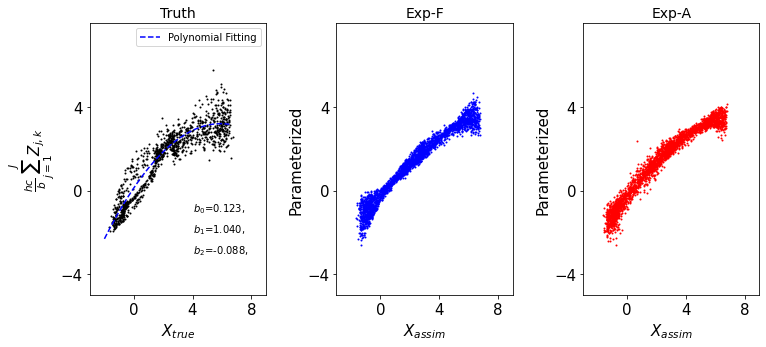

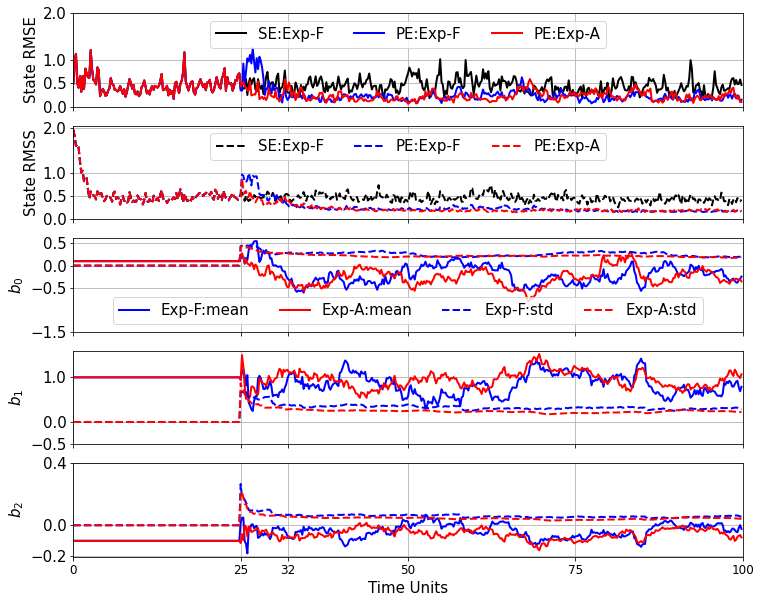

In [46]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.scatter(Xu[range(600,2000,10)],Para_true[range(600,2000,10)],s=1,c='k')
plt.plot(xtt,gU(xtt),'b--',label='Polynomial Fitting')
plt.ylim(-5,8);plt.xlim(-3,9)
for j in range(len(z)):
    plt.text(4,-1-j,r'$b_'+str(j)+'$=%.3f'%z[2-j]+',',fontsize=10)
plt.ylabel(r'$\frac{hc}{b}\sum_{j=1}^{J} Z_{j,k}$',fontsize=15);plt.xlabel(r'$X_{true}$',fontsize=15)
plt.xticks(np.arange(0,12,4),fontsize=15);plt.yticks(np.arange(-4,8,4),fontsize=15)
plt.legend(fontsize=10)
plt.title('Truth',fontsize=14)
#
plt.subplots_adjust(wspace=0.4,hspace=0)
plt.subplot(1,3,2)
plt.scatter(meanXana1[range(150,500)],meanPara1[range(150,500)],s=1,c='b')
plt.ylim(-5,8);plt.xlim(-3,9)
plt.xlabel(r'$X_{assim}$',fontsize=15);plt.ylabel('Parameterized',fontsize=15)
plt.xticks(np.arange(0,12,4),fontsize=15);plt.yticks(np.arange(-4,8,4),fontsize=15)
plt.title('Exp-F',fontsize=14)
plt.subplot(1,3,3)
plt.scatter(meanXana1[range(150,500)],meanPara2[range(150,500)],s=1,c='r')
plt.ylim(-5,8);plt.xlim(-3,9)
plt.xlabel(r'$X_{assim}$',fontsize=15);plt.ylabel('Parameterized',fontsize=15)
plt.xticks(np.arange(0,12,4),fontsize=15);plt.yticks(np.arange(-4,8,4),fontsize=15)
plt.title('Exp-A',fontsize=14)

PCmean1 = np.mean(PCa1,axis=1)
PCstd1 = np.std(PCa1,axis=1)
PCmean2 = np.mean(PCa2,axis=1)
PCstd2 = np.std(PCa2,axis=1)
for j in range(125):
    PCmean1[j]=pC0
    PCmean2[j]=pC0

    
TMP_DAT = np.load(case_dir+'output/se_2obs_cmp.npz')
Xassim=TMP_DAT['arr_0'];Xspread=TMP_DAT['arr_1']
Err1 = Xassim-Xu;Spd1 = Xspread
TMP_DAT = np.load(case_dir+'output/pe_online_2obs.npz')
Xassim=TMP_DAT['arr_0'];Xspread=TMP_DAT['arr_1']
Err2 = Xassim-Xu;Spd2 = Xspread
TMP_DAT = np.load(case_dir+'output/pe_online_2obs_adp.npz')
Xassim=TMP_DAT['arr_0'];Xspread=TMP_DAT['arr_1']
Err3 = Xassim-Xu;Spd3 = Xspread
tRMSE1 = np.sqrt(np.mean(np.square(Err1),axis=1))
tRMSE2 = np.sqrt(np.mean(np.square(Err2),axis=1))
tRMSE3 = np.sqrt(np.mean(np.square(Err3),axis=1))
tRMSS1 = np.sqrt(np.mean(np.square(Spd1),axis=1))
tRMSS2 = np.sqrt(np.mean(np.square(Spd2),axis=1))
tRMSS3 = np.sqrt(np.mean(np.square(Spd3),axis=1))

plt.figure(figsize=(12,10))
plt.subplot(5,1,1)
plt.plot(np.arange(0,assim_period,4)*dt,tRMSE1[range(0,assim_period,4)],'k',lw=2,label='SE:Exp-F')
plt.plot(np.arange(0,assim_period,4)*dt,tRMSE2[range(0,assim_period,4)],'b',lw=2,label='PE:Exp-F')
plt.plot(np.arange(0,assim_period,4)*dt,tRMSE3[range(0,assim_period,4)],'r',lw=2,label='PE:Exp-A')
plt.ylabel('State RMSE',fontsize=15);plt.yticks([0,0.5,1,2],fontsize=15)
plt.xticks([0,25,32,50,75,100],[]);plt.xlim(0,100.01)
plt.grid();plt.legend(ncol=3,fontsize=15,loc=9)

plt.subplot(5,1,2)
plt.plot(np.arange(0,assim_period,4)*dt,tRMSS1[range(0,assim_period,4)],'k--',lw=2,label='SE:Exp-F')
plt.plot(np.arange(0,assim_period,4)*dt,tRMSS2[range(0,assim_period,4)],'b--',lw=2,label='PE:Exp-F')
plt.plot(np.arange(0,assim_period,4)*dt,tRMSS3[range(0,assim_period,4)],'r--',lw=2,label='PE:Exp-A')
plt.ylabel('State RMSS',fontsize=15);plt.yticks([0,0.5,1,2],fontsize=15)
plt.xticks([0,25,32,50,75,100],[],fontsize=15);plt.xlim(0,100.01)
plt.grid();plt.legend(ncol=3,fontsize=15,loc=9)

plt.subplot(5,1,3)
plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCmean1[:,2],'b',lw=2,label='Exp-F:mean')
plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCmean2[:,2],'r',lw=2,label='Exp-A:mean')
plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCstd1[:,2],'b--',lw=2,label='Exp-F:std')
plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCstd2[:,2],'r--',lw=2,label='Exp-A:std')
plt.xticks([0,25,32,50,75,100],[],fontsize=12);plt.xlim(0,100.01)
plt.ylabel(r'$b_0$',fontsize=15);plt.yticks([-1.5,-0.5,0,0.5],fontsize=15)
plt.grid();plt.legend(ncol=4,fontsize=15,loc=8)

plt.subplot(5,1,4)
plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCmean1[:,1],'b',lw=2,label='Exp-F:mean')
plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCmean2[:,1],'r',lw=2,label='Exp-A:mean')
plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCstd1[:,1],'b--',lw=2,label='Exp-F:std')
plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCstd2[:,1],'r--',lw=2,label='Exp-A:std')
plt.xticks([0,25,32,50,75,100],[],fontsize=12);plt.xlim(0,100.01)
plt.ylabel(r'$b_1$',fontsize=15);plt.yticks([-0.5,0,1],fontsize=15)
plt.grid()

plt.subplot(5,1,5)
plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCmean1[:,0],'b',lw=2,label='Exp-F:mean')
plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCmean2[:,0],'r',lw=2,label='Exp-A:mean')
plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCstd1[:,0],'b--',lw=2,label='Exp-F:std')
plt.plot(dt*np.arange(0,assim_period,obs_every_n_steps),PCstd2[:,0],'r--',lw=2,label='Exp-A:std')
plt.xticks([0,25,32,50,75,100],fontsize=12);plt.xlim(0,100.01)
plt.ylabel(r'$b_2$',fontsize=15);plt.yticks([-0.2,0,0.4],fontsize=15)
plt.xlabel('Time Units',fontsize=15)
plt.grid()
#plt.savefig(case_dir+'figure6.eps',format='eps')

In [19]:
print(tRMSE1[1500:-1].mean())
print(tRMSE2[1500:-1].mean())
print(tRMSE3[1500:-1].mean())

0.42054501234353403
0.1964933661075692
0.20724589864384715


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


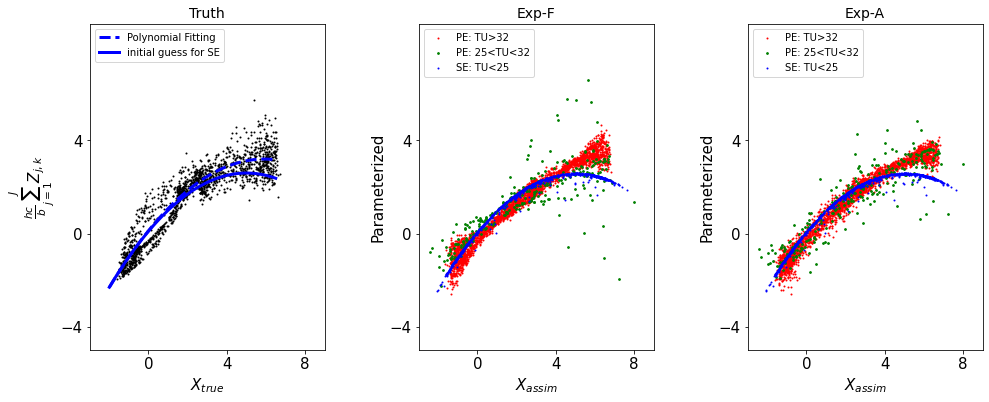

In [47]:
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.scatter(Xu[range(0,2000,10)],Para_true[range(0,2000,10)],s=1,c='k')
plt.plot(xtt,gU(xtt),'b--',lw=3,label='Polynomial Fitting')
plt.plot(xtt,zU(xtt),'b-',lw=3,label='initial guess for SE')
plt.ylim(-5,9);plt.xlim(-3,9)
#for j in range(len(z)):
#    plt.text(4,-1-j,r'$b_'+str(j)+'$=%.3f'%z[2-j]+',',fontsize=10)
plt.ylabel(r'$\frac{hc}{b}\sum_{j=1}^{J} Z_{j,k}$',fontsize=15);plt.xlabel(r'$X_{true}$',fontsize=15)
plt.xticks(np.arange(0,12,4),fontsize=15);plt.yticks(np.arange(-4,8,4),fontsize=15)
plt.legend(fontsize=10,loc=2)
plt.title('Truth',fontsize=14)
#
plt.subplots_adjust(wspace=0.4,hspace=0)
plt.subplot(1,3,2)
plt.scatter(meanXana1[range(160,500)],meanPara1[range(160,500)],s=1,c='r',label='PE: TU>32')
plt.scatter(meanXana1[range(125,160)],meanPara1[range(125,160)],s=3,c='g',label='PE: 25<TU<32')
plt.scatter(meanXana1[range(124)],meanPara1[range(124)],s=1,c='b',label='SE: TU<25')
plt.ylim(-5,9);plt.xlim(-3,9)
plt.xlabel(r'$X_{assim}$',fontsize=15);plt.ylabel('Parameterized',fontsize=15)
plt.xticks(np.arange(0,12,4),fontsize=15);plt.yticks(np.arange(-4,8,4),fontsize=15)
plt.title('Exp-F',fontsize=14)
plt.legend(loc=2,fontsize=10)
plt.subplot(1,3,3)
plt.scatter(meanXana1[range(160,500)],meanPara2[range(160,500)],s=1,c='r',label='PE: TU>32')
plt.scatter(meanXana1[range(125,160)],meanPara2[range(125,160)],s=3,c='g',label='PE: 25<TU<32')
plt.scatter(meanXana1[range(124)],meanPara2[range(124)],s=1,c='b',label='SE: TU<25')
plt.ylim(-5,9);plt.xlim(-3,9)
plt.xlabel(r'$X_{assim}$',fontsize=15);plt.ylabel('Parameterized',fontsize=15)
plt.xticks(np.arange(0,12,4),fontsize=15);plt.yticks(np.arange(-4,8,4),fontsize=15)
plt.title('Exp-A',fontsize=14)
plt.legend(loc=2,fontsize=10)
plt.savefig(case_dir+'figure7.eps',format='eps')